In [93]:
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict


from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore


from dotenv import load_dotenv
import os
from langchain.document_loaders import JSONLoader
import numpy as np
import matplotlib.pyplot as plt


In [94]:
load_dotenv(override=True)  # This will load environment variables from .env file

True

In [95]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large") ## why?
vector_store = InMemoryVectorStore(embeddings) # why?
llm = ChatOpenAI(model="gpt-4o-mini") # why?

In [96]:
# Create loaders for each JSON file
loader1 = JSONLoader(
    file_path="userModel/how.json",
    jq_schema='.', #Get everything (entire JSON)
    text_content=False
)

loader2 = JSONLoader(
    file_path="userModel/whereTo.json",
    jq_schema='.', #Get everything (entire JSON)
    text_content=False
)

loader3 = JSONLoader(
    file_path="userModel/who.json",
    jq_schema='.', #Get everything (entire JSON)
    text_content=False
)

# Combine documents from all loaders
documents = []
for loader in [loader1, loader2, loader3]:
    documents.extend(loader.load())


In [97]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200, 
    chunk_overlap=40,
    separators=["{", "}", ",", "\n"]
    )
all_splits = text_splitter.split_documents(documents)

In [98]:
print(len(all_splits))
for doc in all_splits:
    print(doc)

32
page_content='{"subPlan": [{"goal":' metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}
page_content='{"description": "Secure a job in Software Engineering or Machine Learning", "deadline": "2025-03-31"' metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}
page_content='}, "justification": "Jimmy has a strong passion for continuous improvement, making a positive difference, and leveraging his skills in programming and problem-solving.", "actionItem": [' metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}
page_content='{"what": "Complete and refine resume and LinkedIn profile", "when": "2025-01-07", "duration": "2 hours"},' metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}
page_content='{"what": "Apply to at least 5 jobs weekl

In [99]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

In [108]:
whoSchema = """{
    Name: string,
    DOB: string,  // ISO date format
    Gender: string,
    "Core Values": string[],
    "Personality Traits": string[],
    "Hobbies/Interests": string[]
    }"""
whereToSchema = """{
desires: Array<{
    description: string,
    strength: number,  // Scale 1-10
    timeliness: string // Time period or "Ongoing"
}>
}"""
howSchema = """{
subPlan: Array<{
    goal: {
        description: string,
        deadline: string  // ISO date format
    },
    justification: string,
    actionItems: Array<{
        what: string,
        when: string,    // Schedule description
        duration: string  // Time period
    }>
}>
}"""
whoDescription = "personal information about the user."
whereToDescription = "information about the user's most important desires."
howDescription = "information about the user's plan to obtain each of their desires from a high level."
dataSourcesAndDescriptions = [(whoSchema, whoDescription), (whereToSchema, whereToDescription), (howSchema, howDescription)]

In [122]:
# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def getScore(cosineSimilarity):
    return cosineSimilarity #abs(cosineSimilarity)
# Define application steps

def retrieve2(state: State, minRelevance = 0.2, stdDev = 0.5, showDistribution = True):
    researchPromptFXN = lambda question, schema, description: f"""You are preparing to answer the following 
    question: {question}. You are given access to a json database that contains {description} with 
    the following schema: {schema}. Generate a list of newline-separated, natural language queries 
    that will help you answer the question."""
    
    question = state["question"]
    relevantDocs = {}
    for schema, description in dataSourcesAndDescriptions:
        newDocs = research(schema, description, question, researchPromptFXN)
        for doc in newDocs:
            relevantDocs[doc.id] = doc
    return {"context": list(relevantDocs.values())}
    

def research(schema, description, question: str, promptFXN, numStdDev = 1, threshold = 0.2):
    def getMostRelevant(raw_results):
        scores = np.array([getScore(cosine_similarity) for _, cosine_similarity in raw_results])
        mean = np.mean(scores)
        std = np.std(scores)
        return [raw_results[i][0] for i in np.where(scores >= mean + (std*numStdDev))[0] if raw_results[i][1] >= threshold]
    
    prompt = promptFXN(question, schema, description)
    response = llm.invoke(prompt)
    print(prompt, response)
    desiredInformation = response.content.split("\n") # split into specific "queries"
    docs = {}
    for query in desiredInformation:
        relevant = getMostRelevant(vector_store.similarity_search_with_score(query))
        for doc in relevant:
            docs[doc.id] = doc
    return list(docs.values())

def retrieve(state: State, minRelevance = 0.2, stdDev = 1, showDistribution = True, document = None):
    raw_results = vector_store.similarity_search_with_score(state["question"], k = len(all_splits)) # score is cosine similarity
    print("len raw_results", len(raw_results))
    if len(raw_results) == 1:
        return {"context": [raw_results[0][0]]}
    else:
        # I think absolute value of score measures true similarity, will test this hypothesis somehow
        scores = np.array([getScore(cosine_similarity) for _, cosine_similarity in raw_results])
        indicesAboveMinRelevance = np.where(scores > minRelevance)[0]
        #meanScore = np.mean(scores)
        #stdScore = np.std(scores)
        if showDistribution:
            plt.hist(scores)
            plt.show()

        if len(indicesAboveMinRelevance):
            return {"context": [raw_results[i][0] for i in indicesAboveMinRelevance]} # return all documents above minRelevance
        else:
            #maxScoreIndex = np.argmax(scores)
            return {"context": [raw_results[0][0]]} # return the most relevant documen

def generate(state: State):
    print("state['context']", state["context"])
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

def generate2(state: State):
    prompt = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question."""
    who, how, whereTo = [], [], []
    for doc in state["context"]:
        if "who" in doc.metadata["source"]:
            who.append(doc.page_content)
        elif "how" in doc.metadata["source"]:
            how.append(doc.page_content)
        elif "whereTo" in doc.metadata["source"]:
            whereTo.append(doc.page_content)
    if who:
        who_content = "\n\n".join(who)
        prompt += f"Context about {whoDescription}: {who_content}\n."
    if whereTo:
        whereTo_content = "\n\n".join(whereTo)
        prompt += f"Context about {whereToDescription}: {whereTo_content}\n."
    if how:
        how_content = "\n\n".join(how)
        prompt += f"Context about {howDescription}: {how_content}\n."
    
    prompt += f"Question: {state['question']}\n."
    print(prompt)
    response = llm.invoke(prompt)
    return {"answer": response.content}


C:\Users\garre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [120]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

graph_builder2 = StateGraph(State).add_sequence([retrieve2, generate2])
graph_builder2.add_edge(START, "retrieve2")
graph2 = graph_builder2.compile()



len raw_results 32


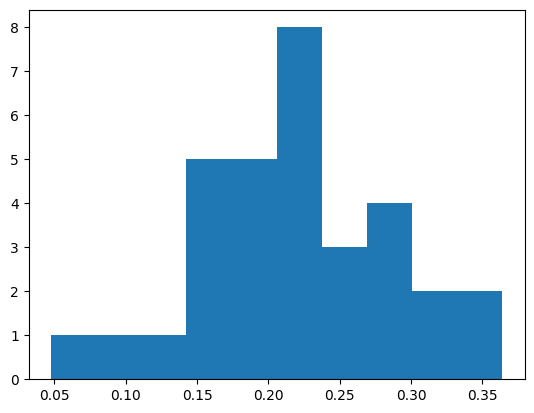

state['context'] [Document(id='6ad69418-b1d8-4fcb-85f5-83afa92df118', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"what": "Develop a morning routine with exercise and mindfulness", "when": "Daily, 7:00 AM", "duration": "1 hour"},'), Document(id='d4478e8c-2239-425a-972e-d082fbb942e5', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"what": "Apply to at least 5 jobs weekly", "when": "Mondays and Thursdays", "duration": "3 hours each day"},'), Document(id='3fae4a6a-a715-48a5-95a9-ce387a10cc4c', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"what": "Visit potential apartments", "when": "March weekends", "duration": "3 hours per weekend"}]}, {"goal":'), Document(id='364dd96d-4fc1-43f4-8b6f-05d7aef2542f', metadata={'source': 'C:\\Users

TypeError: generate2() missing 3 required positional arguments: 'whoDescription', 'whereToDescription', and 'howDescription'

In [121]:
question = "Given your knowledge of where I'd like to go, and the plan we've agreed upon, what should I be doing on a daily basis?"
graph.invoke({"question": question})
print()
graph2.invoke({"question": question})


len raw_results 32


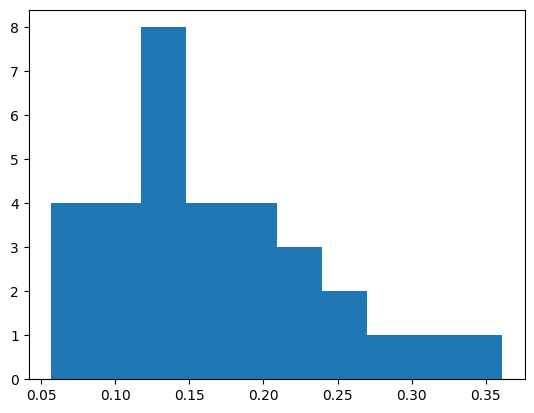

state['context'] [Document(id='7421666e-3a8e-40fd-91f3-d220eea7d612', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"what": "Apply to at least 5 jobs weekly", "when": "Mondays and Thursdays", "duration": "3 hours each day"},'), Document(id='1dd2a9c2-42d8-4ecc-954b-3f4e809173bb', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\whereTo.json', 'seq_num': 1}, page_content='{"description": "Secure a job in Software Engineering or Machine Learning", "strength": 10, "timeliness": "3 months"},'), Document(id='e4ec5139-ae7d-42a3-9ab1-2bd1cb66ee76', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"what": "Complete and refine resume and LinkedIn profile", "when": "2025-01-07", "duration": "2 hours"},'), Document(id='316eb6db-95c5-4cd4-8a0e-847cf855ca1a', metadata={'source': 'C:\\Users

{'question': "What's the best way for me to approach the job search, given what you know about me?",
 'context': [Document(id='7421666e-3a8e-40fd-91f3-d220eea7d612', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"what": "Apply to at least 5 jobs weekly", "when": "Mondays and Thursdays", "duration": "3 hours each day"},'),
  Document(id='1dd2a9c2-42d8-4ecc-954b-3f4e809173bb', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\whereTo.json', 'seq_num': 1}, page_content='{"description": "Secure a job in Software Engineering or Machine Learning", "strength": 10, "timeliness": "3 months"},'),
  Document(id='e4ec5139-ae7d-42a3-9ab1-2bd1cb66ee76', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"what": "Complete and refine resume and LinkedIn profile", "when": "2025-01-07", "duration

In [92]:
graph.invoke({"question": "What's the best way for me to approach the job search, given what you know about me?"})

len raw_results 32


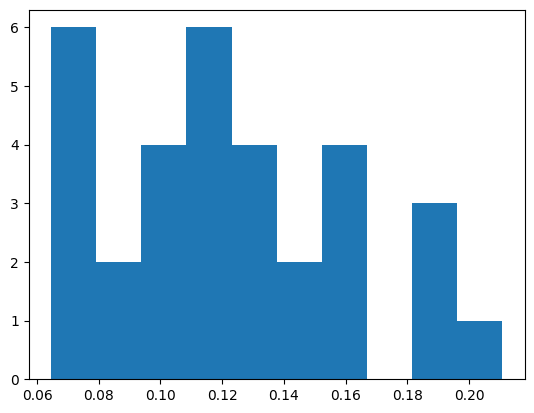

state['context'] [Document(id='a1157d38-7591-4ce0-8557-d9d16b52230d', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\who.json', 'seq_num': 1}, page_content='}')]


{'question': 'this has nothing to do with the project, curiousity killed the cat',
 'context': [Document(id='a1157d38-7591-4ce0-8557-d9d16b52230d', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\who.json', 'seq_num': 1}, page_content='}')],
 'answer': "I don't know."}

In [103]:
graph.invoke({"question": "this has nothing to do with the project, curiousity killed the cat"})

In [ ]:
graph.invoke({"question": "this has nothing to do with the project, curiousity killed the cat"})

len raw_results 32


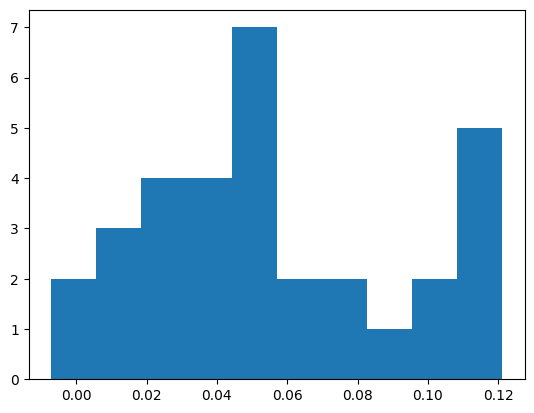

state['context'] [Document(id='4515ff90-ecdd-4696-ab93-6619f5f3a67e', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"what": "Attend social mixers or community events monthly", "when": "Last Friday of each month", "duration": "3 hours"},')]


{'question': 'A donkey and a parrot walked into a bar. What happens next?',
 'context': [Document(id='4515ff90-ecdd-4696-ab93-6619f5f3a67e', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"what": "Attend social mixers or community events monthly", "when": "Last Friday of each month", "duration": "3 hours"},')],
 'answer': "I don't know."}

In [104]:
graph.invoke({"question": "A donkey and a parrot walked into a bar. What happens next?"})

len raw_results 32


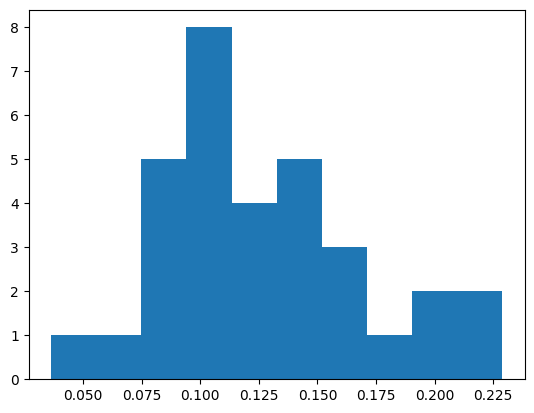

state['context'] [Document(id='acc427a8-28cc-40ec-85e2-299b748b906a', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"description": "Secure a job in Software Engineering or Machine Learning", "deadline": "2025-03-31"'), Document(id='385b64e2-ac81-4b88-8516-c9bf5a845324', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\whereTo.json', 'seq_num': 1}, page_content='{"description": "Secure a job in Software Engineering or Machine Learning", "strength": 10, "timeliness": "3 months"},')]


{'question': 'I am very interested in Arize AI. Tell me more about what they do.',
 'context': [Document(id='acc427a8-28cc-40ec-85e2-299b748b906a', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"description": "Secure a job in Software Engineering or Machine Learning", "deadline": "2025-03-31"'),
  Document(id='385b64e2-ac81-4b88-8516-c9bf5a845324', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\whereTo.json', 'seq_num': 1}, page_content='{"description": "Secure a job in Software Engineering or Machine Learning", "strength": 10, "timeliness": "3 months"},')],
 'answer': "I don't know."}

In [105]:
graph.invoke({"question": "I am very interested in Arize AI. Tell me more about what they do."})

len raw_results 32


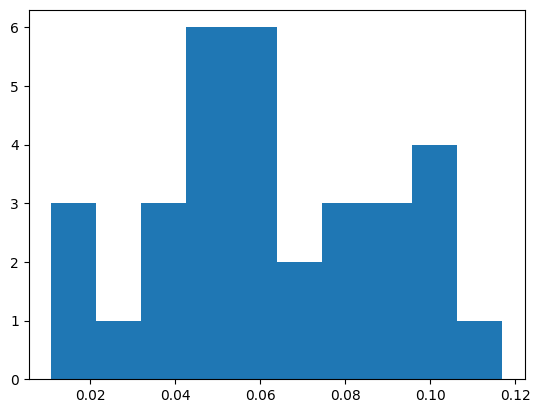

state['context'] [Document(id='4515ff90-ecdd-4696-ab93-6619f5f3a67e', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"what": "Attend social mixers or community events monthly", "when": "Last Friday of each month", "duration": "3 hours"},')]


{'question': 'my milkshake brings all the boys to the yard. What is a milkshake?',
 'context': [Document(id='4515ff90-ecdd-4696-ab93-6619f5f3a67e', metadata={'source': 'C:\\Users\\garre\\OneDrive\\Desktop\\Projects\\personAIble\\userModel\\how.json', 'seq_num': 1}, page_content='{"what": "Attend social mixers or community events monthly", "when": "Last Friday of each month", "duration": "3 hours"},')],
 'answer': "I don't know."}

In [106]:
graph.invoke({"question": "my milkshake brings all the boys to the yard. What is a milkshake?"})